In [1]:
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error
import math
import random
import numpy as np
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import scipy.stats as stats

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")

#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
np.random.seed(1)

data = np.array(data)
data = np.reshape(data, (-1, 1))
data

C:\Users\koush\anaconda3\envs\LSBU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


array([[1316],
       [1264],
       [1305],
       ...,
       [2116],
       [2304],
       [2388]], dtype=int64)

In [2]:
def objective(hyperparams):
        
        n,lags,w_lo,w_hi,b_lo,b_hi = hyperparams
        m= int(lags)
        per = (1736 - m)/1826
        size = int(len(data) * per)
        d_train, d_test = data[0:size], data[size:len(data)]

        mean_train = np.mean(d_train)
        sd_train = np.std(d_train)
        d_train = (d_train-mean_train)/sd_train
        d_test = (d_test-mean_train)/sd_train
        X_train = np.array([d_train[i][0] for i in range(m)])
        y_train = np.array(d_train[m][0])

        for i in range(1,(d_train.shape[0]-m)):
            l = np.array([d_train[j][0] for j in range(i,i+m)])
            X_train = np.vstack([X_train,l])
            y_train = np.vstack([y_train,d_train[i+m]])
    
        #auto corrected input vector for test
        X_test = np.array([d_test[i][0] for i in range(m)])
        y_test = np.array(d_test[m][0])

        for i in range(1,(d_test.shape[0]-m)):
            l = np.array([d_test[j][0] for j in range(i,i+m)])
            X_test = np.vstack([X_test,l])
            y_test = np.vstack([y_test,d_test[i+m]])
        input_size = X_train.shape[1]
        hidden_size = int(n)   #no. of hidden neurons
        mu, sigma = 0, 1
         #initialising input weights and biases randomly drawn from a truncated normal distribution
        input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
        biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
        
        def relu(x):      #hidden layer activation function
            return np.maximum(x, 0, x)
        
        def hidden_nodes(X):
            G = np.dot(X, input_weights)
            G = G + biases
            H = relu(G)
            return H

        output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

        def predict(X):
            out = hidden_nodes(X)
            out = np.dot(out, output_weights)
            return out

        prediction = predict(X_test)

        # evaluate forecasts
        rmse = math.sqrt(mean_squared_error(y_test, prediction))
    
        return rmse

# Set limits for Differential Evolution
n_lim = (1,1826)
lags_lim = (1,275)
wlo_lim = (-5,-0.5)
whi_lim = (0.5,5)
blo_lim = (-5,-0.5)
bhi_lim = (0.5,5)
boundaries = [n_lim] + [lags_lim] + [wlo_lim] + [whi_lim] + [blo_lim] + [bhi_lim] 
# Set up Differential Evolution solver
solver = differential_evolution(objective,boundaries,maxiter =500,strategy='best1bin',popsize=15,mutation=0.5,recombination=0.7,tol=0.01,seed=2020)
# Calculate best hyperparameters and resulting rmse
best_hyperparams = solver.x
best_rmse = solver.fun
# Print final results
print("Converged hyperparameters: No. of hidden nodes = %.6f, No. of lags = %.6f, Lower limit of input weights = %.6f, Upper limit of input weights = %.6f, Lower limit of biases = %.6f, Upper limit of biases = %.6f" %(best_hyperparams[0],best_hyperparams[1],best_hyperparams[2],best_hyperparams[3],best_hyperparams[4],best_hyperparams[5]))    
print("Minimum rmse: %.6f" %(best_rmse))

Converged hyperparameters: No. of hidden nodes = 1803.454466, No. of lags = 194.369830, Lower limit of input weights = -0.549497, Upper limit of input weights = 4.117357, Lower limit of biases = -2.123296, Upper limit of biases = 2.847554
Minimum rmse: 0.172350


In [3]:
np.random.seed(1)

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")

#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data = np.array(data)
data = np.reshape(data, (-1, 1))
#splitting data into test and train parts, Forecasting demand for last 3 months, (have to consider 3 months + m days to account for input features)
m= int(best_hyperparams[1])
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]

mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

# Converting data into 2d array combining time steps for directly feeding into ELM

#auto corrected input vector for training (we are taking m lagged values as features for each data point)
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])

for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
    
#auto corrected input vector for test
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])

for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
    
best_score, best_input_weights,best_biases = float("inf"), None,None

for i in range(1,100):
    input_size = X_train.shape[1]
    hidden_size = int(best_hyperparams[0])   #no. of hidden neurons

    w_lo = best_hyperparams[2]
    w_hi = best_hyperparams[3]
    b_lo = best_hyperparams[4]
    b_hi = best_hyperparams[5]
    mu, sigma = 0, 1
    #initialising input weights and biases randomly drawn from a truncated normal distribution
    input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
    biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
    
    def relu(x):      #hidden layer activation function
        return np.maximum(x, 0, x)
    def step(x):
        return np.heaviside(x, 1)
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))    
    
    def gaussian(x):
        return np.exp(-(x*x))
    
    def arctangent(x):
        return np.arctan(x)
    
    def tanh(x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def hidden_nodes(X):
        G = np.dot(X, input_weights)
        G = G + biases
        H = relu(G)
        return H

    output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

    def predict(X):
        out = hidden_nodes(X)
        out = np.dot(out, output_weights)
        return out

    prediction = predict(X_test)
    total = X_test.shape[0]
    
    # evaluate forecasts
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    print('Test RMSE: %.3f' % rmse)
    mape_sum = 0
    for i,j in zip(y_test,prediction):
        mape_sum = mape_sum + (abs((i-j)/i))
    mape = (mape_sum/total)*100
    mpe_sum = 0
    for i,j in zip(y_test,prediction):
        mpe_sum = mpe_sum + ((i-j)/i)
    mpe = (mpe_sum/total)*100
    print('Test MAPE: %.3f' % mape)
    print('Test MPE: %.3f' % mpe)
    if rmse < best_score:
        best_score, best_input_weights,best_biases = rmse, input_weights,biases
        
print("Best RMSE = ",best_score)

Test RMSE: 0.178
Test MAPE: 49.446
Test MPE: 16.206
Test RMSE: 0.181
Test MAPE: 56.692
Test MPE: 23.509
Test RMSE: 0.202
Test MAPE: 63.728
Test MPE: 18.695
Test RMSE: 0.176
Test MAPE: 56.196
Test MPE: 22.370
Test RMSE: 0.173
Test MAPE: 50.983
Test MPE: 19.342
Test RMSE: 0.177
Test MAPE: 55.365
Test MPE: 23.501
Test RMSE: 0.185
Test MAPE: 56.810
Test MPE: 22.906
Test RMSE: 0.177
Test MAPE: 54.641
Test MPE: 21.485
Test RMSE: 0.178
Test MAPE: 53.420
Test MPE: 22.043
Test RMSE: 0.175
Test MAPE: 52.537
Test MPE: 22.897
Test RMSE: 0.173
Test MAPE: 48.365
Test MPE: 15.735
Test RMSE: 0.184
Test MAPE: 56.019
Test MPE: 16.340
Test RMSE: 0.177
Test MAPE: 54.889
Test MPE: 18.442
Test RMSE: 0.169
Test MAPE: 52.724
Test MPE: 23.352
Test RMSE: 0.182
Test MAPE: 55.224
Test MPE: 19.936
Test RMSE: 0.179
Test MAPE: 55.502
Test MPE: 18.852
Test RMSE: 0.176
Test MAPE: 52.298
Test MPE: 22.215
Test RMSE: 0.174
Test MAPE: 52.259
Test MPE: 17.678
Test RMSE: 0.179
Test MAPE: 44.990
Test MPE: 17.828
Test RMSE: 0

Test RMSE: 92.697
Test MAPE: 3.035
Test MPE: 0.194


([<matplotlib.axis.XTick at 0x28e0f07f4a8>,
 <a list of 5 Text xticklabel objects>)

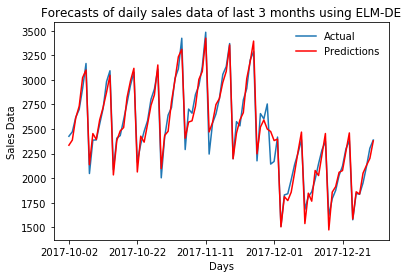

In [4]:
#Making forecasts with best ELM possible


#initialising input weights and biases randomly drawn from a Gaussian distribution
input_weights = best_input_weights
biases = best_biases

def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)
def step(x):
    return np.heaviside(x, 1)    
def sigmoid(x):
    return 1/(1+np.exp(-x))
def gaussian(x):
    return np.exp(-(x*x))
def arctangent(x):
    return np.arctan(x)
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(X_test)
total = X_test.shape[0]

y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

# plot forecasts against actual outcomes
fig, ax = plt.subplots()
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days')
plt.ylabel('Sales Data')
plt.title('ELM-DE with Test RMSE: '+str(rmse)+ ' ,Test MAPE: '+str(mape[0])+' ,Test MPE: '+str(mpe[0]))
plt.xticks([0,20,40,60,80],['2017-10-02','2017-10-22','2017-11-11','2017-12-01','2017-12-21'])
plt.savefig('ELM-DE plot of Store1.png')  #CHANGE STORE NUMBER HERE